<a href="https://colab.research.google.com/github/prathamshroff/Inventory-Demand-Forecasting/blob/main/inventory-forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependency Installations & Imports

In [1]:
%%capture

# Install Dependencies if you haven't already.
!pip install pandas
!pip install scikit-learn
!pip install pmdarima
!pip install lightgbm
!pip install xgboost
!pip install keras-tuner
!clear

# Import Neccessary Libraries
import random
import lightgbm
import numpy as np
import pandas as pd
import pmdarima as pm
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL

from IPython.display import clear_output

# Data Pre-Processing

In [11]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['sales-history-delhi-5yrs.csv']))
# Dataset is now stored in a Pandas Dataframe

df.head()

Saving sales-history-delhi-5yrs.csv to sales-history-delhi-5yrs (1).csv


,Voucher Number,Reference,Date,Voucher Type,Party Name,Party Alias,Buyer's TIN No.,CST Number,Item Name,Godown,...,Alternate Billed Quantity,Rate,Purchase Rate,Unit,Discount,Discount Amount,Margin,Amount,Purchase/Sales Ledger,Narration
0,PFIDEL001/18-19,PFIDEL001/17-18,3-Apr-18,Sales,Prem Enviromantel Solutions,NaN,03262165823,NaN,"20"" BB L -1""",Main Location,...,NaN,420.0,355.0,Nos,0,NaN,942.82,5040.0,IGST Sale,NaN
1,PFIDEL001/18-19,PFIDEL001/17-18,3-Apr-18,Sales,Prem Enviromantel Solutions,NaN,03262165823,NaN,MEMFLO-4-300-2,Main Location,...,NaN,2700.0,2400.0,Nos,0,NaN,1936.11,13500.0,IGST Sale,NaN
2,PFIDEL001/18-19,PFIDEL001/17-18,3-Apr-18,Sales,Prem Enviromantel Solutions,NaN,03262165823,NaN,"SPG 1354-2.5"" T",Main Location,...,NaN,3100.0,2881.0,Nos,0,NaN,1914.87,18600.0,IGST Sale,NaN
3,PFIDEL002/18-19,PFIDEL002/17-18,3-Apr-18,Sales,Jal Jeevan Engineers,NaN,07670425885,NaN,"FRP 3072 - 4""TB",Main Location,...,NaN,24000.0,20663.0,Nos,0,NaN,6674.00,48000.0,SCGST Sale,NaN
4,PFIDEL002/18-19,PFIDEL002/17-18,3-Apr-18,Sales,Jal Jeevan Engineers,NaN,07670425885,NaN,"FRP 3672 - 4""TB",Main Location,...,NaN,32000.0,26330.0,Nos,0,NaN,11340.00,64000.0,SCGST Sale,NaN


In [12]:
# Replace 'column_to_drop_1' and 'column_to_drop_2' with the names of the columns you want to drop
df = df.drop(['Voucher Number', # Just the Invoice Number Sequentially
              'Reference', # Almost All Empty
              'Voucher Type', # All Same (Sales)
              'Party Alias', # All Empty
              "Buyer's TIN No.", # Many Empty, Correlated to 'Party Name'
              'CST Number', # > 80% All Empty
              'Godown', # All Same (Main-Location)
              'Item Batch', # All Same (Primary-Batch)
              'Acutal Quantity', # All Same as 'Billed Qty'
              'Alternate Actual Quantity', # All-Empty
              'Alternate Billed Quantity', # All-Empty
              'Unit', # All-Same (Nos)
              'Discount', # All-Empty
              'Discount Amount', # All-Empty
              'Narration', # All-Empty
             ], axis=1)
df.head()

,Date,Party Name,Item Name,Billed Quantity,Rate,Purchase Rate,Margin,Amount,Purchase/Sales Ledger
0,3-Apr-18,Prem Enviromantel Solutions,"20"" BB L -1""",12.0,420.0,355.0,942.82,5040.0,IGST Sale
1,3-Apr-18,Prem Enviromantel Solutions,MEMFLO-4-300-2,5.0,2700.0,2400.0,1936.11,13500.0,IGST Sale
2,3-Apr-18,Prem Enviromantel Solutions,"SPG 1354-2.5"" T",6.0,3100.0,2881.0,1914.87,18600.0,IGST Sale
3,3-Apr-18,Jal Jeevan Engineers,"FRP 3072 - 4""TB",2.0,24000.0,20663.0,6674.00,48000.0,SCGST Sale
4,3-Apr-18,Jal Jeevan Engineers,"FRP 3672 - 4""TB",2.0,32000.0,26330.0,11340.00,64000.0,SCGST Sale


In [13]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

df.head()

,Party Name,Item Name,Billed Quantity,Rate,Purchase Rate,Margin,Amount,Purchase/Sales Ledger
Date,,,,,,,,
2018-04-03,Prem Enviromantel Solutions,"20"" BB L -1""",12.0,420.0,355.0,942.82,5040.0,IGST Sale
2018-04-03,Prem Enviromantel Solutions,MEMFLO-4-300-2,5.0,2700.0,2400.0,1936.11,13500.0,IGST Sale
2018-04-03,Prem Enviromantel Solutions,"SPG 1354-2.5"" T",6.0,3100.0,2881.0,1914.87,18600.0,IGST Sale
2018-04-03,Jal Jeevan Engineers,"FRP 3072 - 4""TB",2.0,24000.0,20663.0,6674.00,48000.0,SCGST Sale
2018-04-03,Jal Jeevan Engineers,"FRP 3672 - 4""TB",2.0,32000.0,26330.0,11340.00,64000.0,SCGST Sale


# Feature Engineering

In [55]:
# Group the data by month and item, summing the 'Billed Quantity'
monthly_data = df.groupby([pd.Grouper(freq='M'), 'Item Name'])['Billed Quantity'].sum().reset_index()
print(monthly_data)

# Filter the groups based on the condition that the 'Billed Quantity' is at least 25 every month
filtered_data = monthly_data[monthly_data['Billed Quantity'] >= 25]

# Get unique item names in the filtered DataFrame
unique_items = filtered_data['Item Name'].unique()

           Date              Item Name  Billed Quantity
0    2018-04-30          10" Blue L 1"             24.0
1    2018-04-30           20" BB L -1"             46.0
2    2018-04-30          20" BB L 1.5"             30.0
3    2018-04-30          20" Blue L 1"              9.0
4    2018-04-30        20" Blue L 1/2"             20.0
...         ...                    ...              ...
7198 2023-03-31  TSF 4272 6FL T&B - HH              1.0
7199 2023-03-31  TSF 4872 6FL T&B - HH              2.0
7200 2023-03-31           UV -ECS 004L              5.0
7201 2023-03-31                 VC 1.5             10.0
7202 2023-03-31                  VC 2"              8.0

[7203 rows x 3 columns]


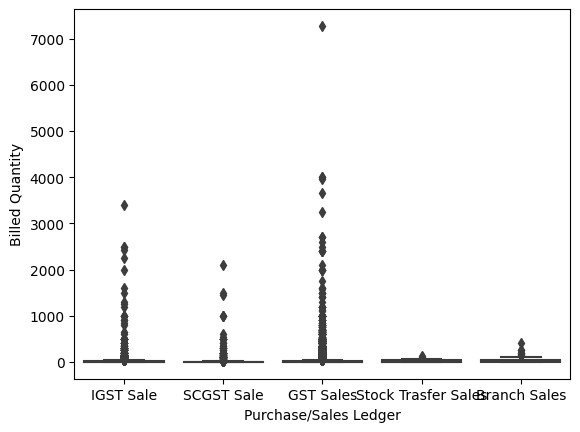

In [15]:
import seaborn as sns

# Create a box plot to visualize the relationship between "Purchase/Sales Ledger" and "Billed Quantity"
sns.boxplot(x='Purchase/Sales Ledger', y='Billed Quantity', data=df)
plt.show()

In [16]:
# Group the data by "Purchase/Sales Ledger" and calculate the mean "Billed Quantity" for each group
grouped_data = df.groupby('Purchase/Sales Ledger')['Billed Quantity'].mean()
print(grouped_data)

Purchase/Sales Ledger
Branch Sales           42.194444
GST Sales              34.607631
IGST Sale              39.628598
SCGST Sale             26.012898
Stock Trasfer Sales    25.040000
Name: Billed Quantity, dtype: float64


In [17]:
import scipy.stats as stats

# Perform ANOVA test
igst_data = df[df['Purchase/Sales Ledger'] == 'IGST Sale']['Billed Quantity']
scgst_data = df[df['Purchase/Sales Ledger'] == 'SCGST Sale']['Billed Quantity']
anova_result = stats.f_oneway(igst_data, scgst_data)

# Check the p-value to determine statistical significance
print(anova_result.pvalue)

0.01068749711356494


# LSTM (Long Short-Term Memory) Time Series

## Implementation 
Here's a breakdown of the steps we will take:

**Prepare the data**: We will scale the 'Billed Quantity' values using MinMaxScaler, which scales the data to a range between 0 and 1. Scaling helps improve the performance and stability of the LSTM model during training.

**Convert the time series to a supervised learning problem**: To train the LSTM model, we will convert the time series data into a supervised learning format where the input is the demand at a given month, and the output is the demand for the following month.

**Split the data into training and test sets**: We will split the data into a training set (80%) and a test set (20%). The training set will be used to train the model, while the test set will be used to evaluate its performance.

**Build and train the LSTM model**: We will create a simple LSTM model with one LSTM layer containing 50 units and a Dense output layer with one unit. The model will be compiled using the Adam optimizer and Mean Squared Error (MSE) loss function. We will train the model for 300 epochs.

**Evaluate the model**: We will use the Mean Absolute Error (MAE) to evaluate the model's performance on the test set.

In [19]:
def prepare_data_LSTM(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data['Billed Quantity'].values.reshape(-1, 1))
    return data, scaler

def lstm_forecast_item_demand(item_name, data, plot=False, min_samples=24, train_size=0.8):
    # Filter the data for the current item
    item_data = data[data['Item Name'] == item_name].set_index('Date').asfreq('M')
    
    # Interpolate missing values using the time method
    item_data['Billed Quantity'] = item_data['Billed Quantity'].interpolate(method='time')

    # Ensure that there are enough samples before running the forecasting model
    if len(item_data) < min_samples:
        print(f"Skipping {item_name} due to insufficient data.")
        return None
    
    # Prepare the data
    data, scaler = prepare_data_LSTM(item_data[['Billed Quantity']])

    # Convert time series to supervised learning problem
    X, y = data[:-1], data[1:]
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM

    # Split the data into training and test sets
    train_size = int(len(X) * train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    try:
        # Build the LSTM model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        # Train the model
        model.fit(X_train, y_train, epochs=300, verbose=0)

        # Make predictions and evaluate the model
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        print(f"Mean Absolute Error for {item_name}: {mae:.4f}")
        
        # Plot the actual demand and predicted demand if plot is True
        if plot:
            
            # Inverse transform the scaled data
            y_train_inv = scaler.inverse_transform(y_train)
            y_test_inv = scaler.inverse_transform(y_test)
            predictions_inv = scaler.inverse_transform(predictions)

            # Plot the data
            plt.figure(figsize=(10, 6))
            plt.plot(item_data.index[1:train_size+1], y_train_inv, label='Actual Train Demand', color='blue', linestyle='dashed')
            plt.plot(item_data.index[train_size+1:], y_test_inv, label='Actual Test Demand', color='blue')
            plt.plot(item_data.index[train_size+1:], predictions_inv, label='Predicted Demand', color='orange')
            plt.title(f"Inventory Demand Forecast for {item_name} (LSTM)")
            plt.xlabel('Date')
            plt.ylabel('Billed Quantity')
            plt.legend()
            plt.show()
            
        return mae

    except ValueError as ve:
        print(f"Skipping {item_name} due to an error: {str(ve)}")
        return None

## LSTM Mean Absolute Error Across Products

In [56]:
# Use the filtered_data DataFrame prepared earlier
mae_values_LSTM = []

# Apply the forecast_item_demand() function to each unique item
for item in unique_items[:10]:
    mae = lstm_forecast_item_demand(item, filtered_data)
    if mae is not None:
        mae_values_LSTM.append(mae)

# Calculate the mean of all MAEs
mean_mae = sum(mae_values_LSTM) / len(mae_values_LSTM)

# Clearing the Individual Mean Errors, Skips & Warnings
clear_output(wait=True)

print(f"Mean Absolute Error across all products: {mean_mae:.2f}")

Mean Absolute Error across all products: 0.11


## LSTM Visualisation

Now that we have implemented the LSTM model and evaluated its performance, let's visualize the predicted demand for 3 randomly-selected products in our dataset. By comparing the actual demand with the predicted demand, we can better understand how well our model is performing.

For each of the selected products, we will create a plot showing the actual demand (in blue) and the predicted demand (in orange) for the test set. This will give us an idea of how closely the model's predictions match the true demand.

1/1 [==============================] - 0s 232ms/step
Mean Absolute Error for BW 30 4040: 0.0580


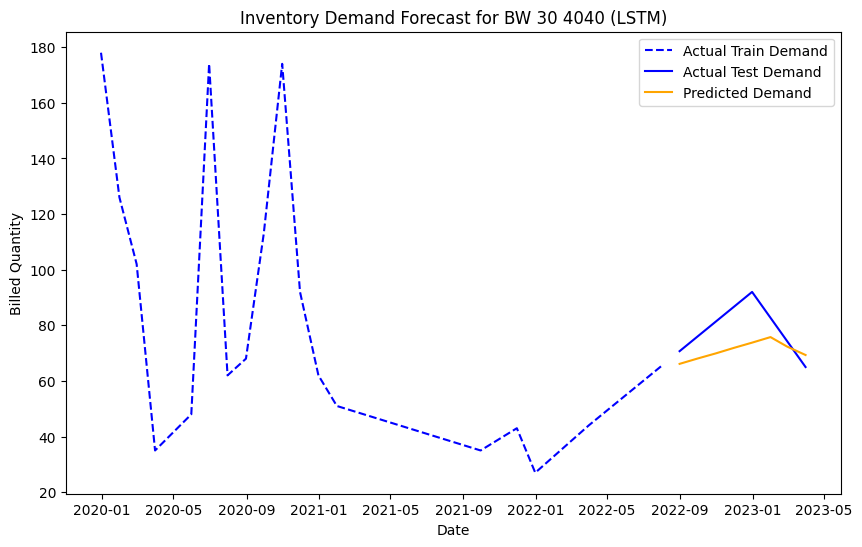

0.05801618574991202

In [20]:
# Select a random product from the list of unique items
random_item = random.choice(unique_items)
lstm_forecast_item_demand(random_item, data=filtered_data, plot=True)

## Hyperparameter Tuning - Keras Tuner HyberBands & EarlyStopping

<ipython-input-57-de5869b9c72d>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


Selected Hyperparameters:
Number of LSTM units: 96


1/1 [==============================] - 1s 710ms/step
Mean Absolute Error: 0.3107


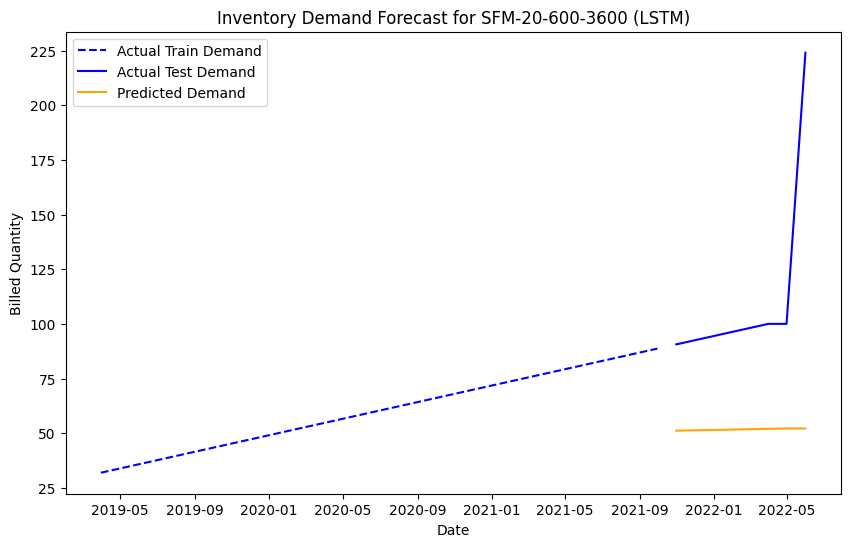

0.31068278191527793

In [57]:
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def prepare_data_LSTM(data):
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data['Billed Quantity'].values.reshape(-1, 1))
    return data, scaler

def lstm_forecast_item_demand(item_name, data, plot=False, min_samples=24, train_size=0.8):
    # Filter the data for the current item
    item_data = data[data['Item Name'] == item_name].set_index('Date').asfreq('M')
    
    # Interpolate missing values using the time method
    item_data['Billed Quantity'] = item_data['Billed Quantity'].interpolate(method='time')

    # Ensure that there are enough samples before running the forecasting model
    if len(item_data) < min_samples:
        print(f"Skipping {item_name} due to insufficient data.")
        return None
    
    # Prepare the data
    data, scaler = prepare_data_LSTM(item_data[['Billed Quantity']])

    # Convert time series to supervised learning problem
    X, y = data[:-1], data[1:]
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM

    # Split the data into training and test sets
    train_size = int(len(X) * train_size)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    try:
        # Define a function to build the model with hyperparameters to tune
        def build_model(hp):
            model = Sequential()
            model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                           activation='relu', input_shape=(1, 1)))
            model.add(Dense(1))
            model.compile(optimizer='adam', loss='mse')
            return model

        # Create a Keras Tuner instance
        tuner = kt.Hyperband(build_model,
                             objective='val_loss',
                             max_epochs=10,
                             factor=3,
                             directory='my_dir',
                             project_name='lstm_tuning')

        # Define a callback to stop training early if the validation loss stops improving
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0)

        # Perform hyperparameter tuning
        tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)

        # Get the best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        
        # Print the selected hyperparameters
        print("Selected Hyperparameters:")
        print("Number of LSTM units:", best_hps.get('units'))

        # Display the summary of the search results
        # tuner.results_summary()
        
        # Build the model with the best hyperparameters
        model = tuner.hypermodel.build(best_hps)

        # Train the model
        history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)

        # Evaluate the model and make predictions
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        print(f"Mean Absolute Error: {mae:.4f}")
        
        # Plot the actual demand and predicted demand if plot is True
        if plot:
            
            # Inverse transform the scaled data
            y_train_inv = scaler.inverse_transform(y_train)
            y_test_inv = scaler.inverse_transform(y_test)
            predictions_inv = scaler.inverse_transform(predictions)

            # Plot the data
            plt.figure(figsize=(10, 6))
            plt.plot(item_data.index[1:train_size+1], y_train_inv, label='Actual Train Demand', color='blue', linestyle='dashed')
            plt.plot(item_data.index[train_size+1:], y_test_inv, label='Actual Test Demand', color='blue')
            plt.plot(item_data.index[train_size+1:], predictions_inv, label='Predicted Demand', color='orange')
            plt.title(f"Inventory Demand Forecast for {item_name} (LSTM)")
            plt.xlabel('Date')
            plt.ylabel('Billed Quantity')
            plt.legend()
            plt.show()
            
        return mae

    except ValueError as ve:
        print(f"Skipping {item_name} due to an error: {str(ve)}")
        return None
    
# Select a random product from the list of unique items
random_item = random.choice(unique_items)
lstm_forecast_item_demand(random_item, data=filtered_data, plot=True)

# Upon execution, if the item has been skipped, just execute again until you see a plot.

## Alternative Time-Series Model Implementation - SARIMAX

In [ ]:
def sarimax_forecast_item_demand(item_name, data, plot=False, train_size=0.8, min_samples=24):
    # Filter data for the specific item
    item_data = data[data['Item Name'] == item_name].set_index('Date').asfreq('M')

    # Interpolate missing values using the time method
    item_data['Billed Quantity'] = item_data['Billed Quantity'].interpolate(method='time')

    # Ensure that there are enough samples before running the forecasting model
    if len(item_data) < min_samples:
        print(f"Skipping {item_name} due to insufficient data.")
        return None
    
    # Split data into training and testing sets
    train_len = int(len(item_data) * train_size)
    train_data = item_data.iloc[:train_len]
    test_data = item_data.iloc[train_len:]
    
    
    try:
        # Use auto_arima to find the best model parameters
        model = pm.auto_arima(train_data['Billed Quantity'], seasonal=True, m=12, suppress_warnings=True)

        # Forecast inventory demand for the test period
        forecast = model.predict(n_periods=len(test_data))

        # Calculate the Mean Absolute Error (MAE)
        mae = mean_absolute_error(test_data['Billed Quantity'], forecast)

    except ValueError as ve:
        print(f"Skipping {item_name} due to an error: {str(ve)}")
        return None

    if plot:
        # Print the MAE and plot the results
        print(f"Mean Absolute Error for {item_name}: {mae:.2f}")
        plt.figure()
        plt.plot(train_data.index, train_data['Billed Quantity'], label='Train')
        plt.plot(test_data.index, test_data['Billed Quantity'], label='Test')
        plt.plot(test_data.index, forecast, label='Forecast')
        plt.title(f"Inventory Demand Forecast for {item_name} (SARIMAX)")
        plt.legend()
        plt.show()

    return mae

# Other Models For Comparison & Better Accuracy
---

## STL Model

In [21]:
def create_lag_features(data, n_lags=12):
    for i in range(1, n_lags+1):
        data[f'Lag_{i}'] = data['Billed Quantity'].shift(i)
    data.dropna(inplace=True)
    return data

def stl_forecast_item_demand(item_name, data, n_lags=12, plot=False, train_size=0.8, min_samples=24):
    item_data = data[data['Item Name'] == item_name].set_index('Date').asfreq('M')
    item_data['Billed Quantity'] = item_data['Billed Quantity'].interpolate(method='time')

    # Ensure that there are enough samples before running the forecasting model
    if len(item_data) < min_samples:
        print(f"Skipping {item_name} due to insufficient data.")
        return None
    
    train_len = int(len(item_data) * train_size)
    train_data = item_data.iloc[:train_len]
    test_data = item_data.iloc[train_len:]

    stl = STL(train_data['Billed Quantity'], period=12)
    res = stl.fit()
    
    # Generate forecast using the seasonal component and the last residual value
    last_resid = res.resid.iloc[-1]
    forecast = res.seasonal[-len(test_data):] + last_resid

    if plot:
        plot_forecast(train_data, test_data, train_data['Billed Quantity'] - res.resid, forecast)

    # Check if forecast and test_data have the same length
    if len(forecast) != len(test_data['Billed Quantity']):
        print("Forecast and test data have different lengths.")
        return None

    mae = mean_absolute_error(test_data['Billed Quantity'], forecast)
    return mae


## LightGBM

In [53]:
def lightgbm_forecast_item_demand(item_name, data, plot=False, train_size=0.8, n_lags=12, min_samples=24):
    item_data = data[data['Item Name'] == item_name].set_index('Date').asfreq('M')
    item_data['Billed Quantity'] = item_data['Billed Quantity'].interpolate(method='time')

    # Ensure that there are enough samples before running the forecasting model
    if len(item_data) < min_samples:
        print(f"Skipping {item_name} due to insufficient data.")
        return None

    # TEST: Additional print statement to see which item is being processed
    # print(f"Processing {item_name} with n_samples={len(item_data)}")
    
    try:
        lag_data = create_lag_features(item_data, n_lags=n_lags)
        lag_data['Item Name'] = lag_data['Item Name'].astype('category')

        X = lag_data.drop('Billed Quantity', axis=1)
        y = lag_data['Billed Quantity']
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)

        model = LGBMRegressor()
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_test_pred)
    
    except ValueError as ve:
        print(f"Skipping {item_name} due to an error: {str(ve)}")
        return None

    if plot:
        print(f"Mean Absolute Error for {item_name}: {mae:.2f}")
        plt.figure()
        plt.plot(item_data.index[:len(X_train)], y_train, label='Train')
        plt.plot(item_data.index[len(X_train):], y_test, label='Test')
        plt.plot(item_data.index[len(X_train):], y_test_pred, label='Forecast')
        plt.title(f"Inventory Demand Forecast for {item_name} (LightGBM)")
        plt.legend()
        plt.show()

    return mae

## XGBoost

In [23]:
def xgboost_forecast_item_demand(item_name, data, plot=False, train_size=0.8, n_lags=3, min_samples=24):

    item_data = data[data['Item Name'] == item_name].set_index('Date').asfreq('M')
    item_data['Billed Quantity'] = item_data['Billed Quantity'].interpolate(method='time')
    
    filtered_data = item_data
    
    filtered_data['Lag_1'] = filtered_data['Billed Quantity'].shift(1)
    filtered_data['Lag_2'] = filtered_data['Billed Quantity'].shift(2)
    filtered_data['Lag_3'] = filtered_data['Billed Quantity'].shift(3)
    filtered_data.dropna(inplace=True)

    # Ensure that there are enough samples before running the forecasting model
    if len(item_data) < min_samples:
        print(f"Skipping {item_name} due to insufficient data.")
        return None
    
    X = filtered_data[['Lag_1', 'Lag_2', 'Lag_3']]
    y = filtered_data['Billed Quantity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=False)

    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    if plot:
        plt.figure()
        plt.plot(filtered_data.index[:-len(y_test)], y_train, label='Train')
        plt.plot(filtered_data.index[-len(y_test):], y_test, label='Test')
        plt.plot(filtered_data.index[-len(y_test):], y_test_pred, label='Forecast')
        plt.title(f"Inventory Demand Forecast for {item_name} (XGBoost)")
        plt.legend()
        plt.show()

    return test_mae

# Visualizations
---

In [24]:
def get_mean_mae_across_products(model, data=filtered_data, length=len(unique_items), plot=False):
    mae_values = []
    for item in unique_items[:length]:
        mae = model(item, data, plot=plot)
        if mae is not None:
            mae_values.append(mae)
    # Return Mean of MAEs
    return sum(mae_values) / len(mae_values)

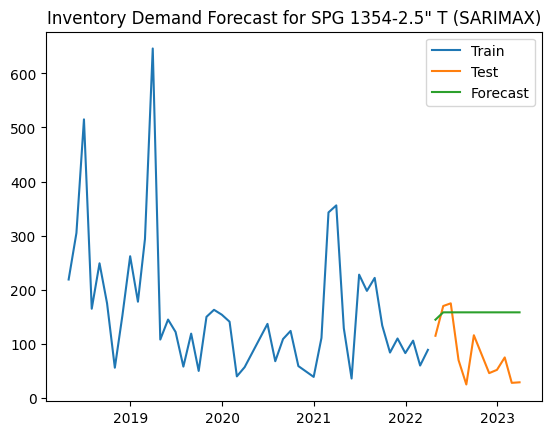

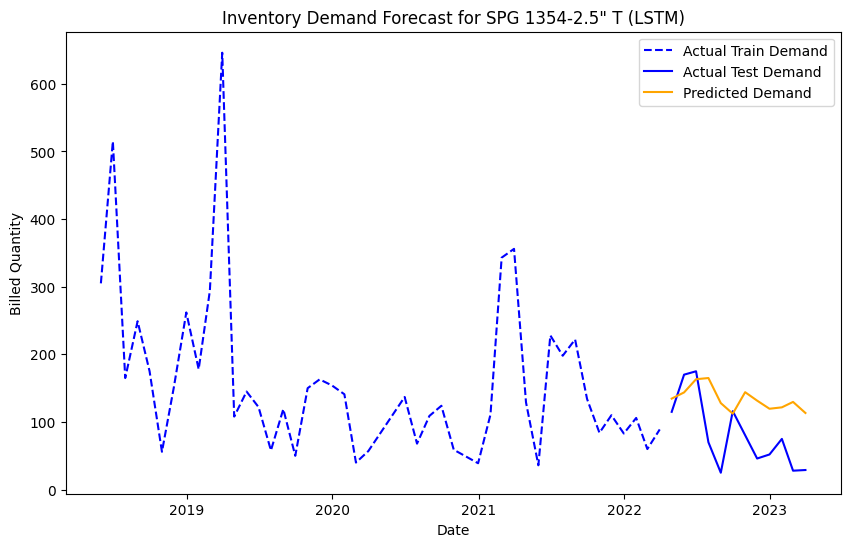

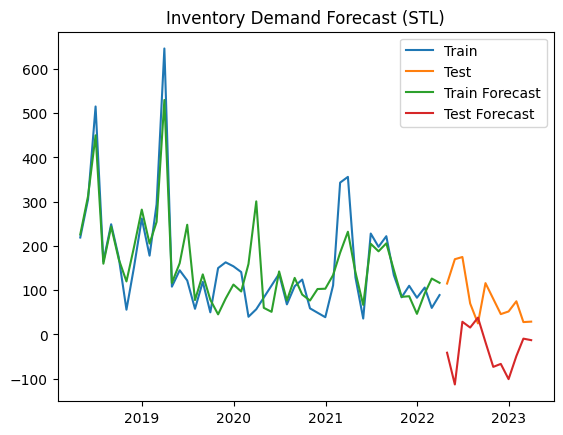

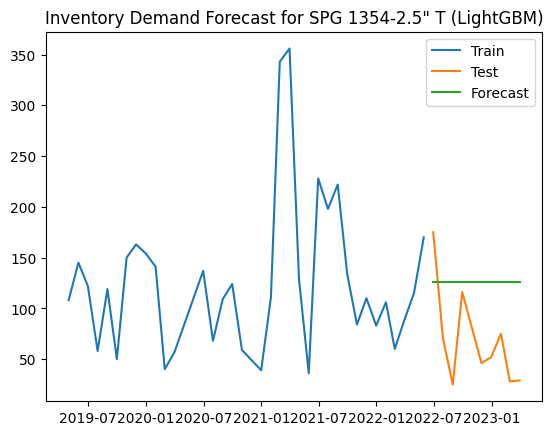

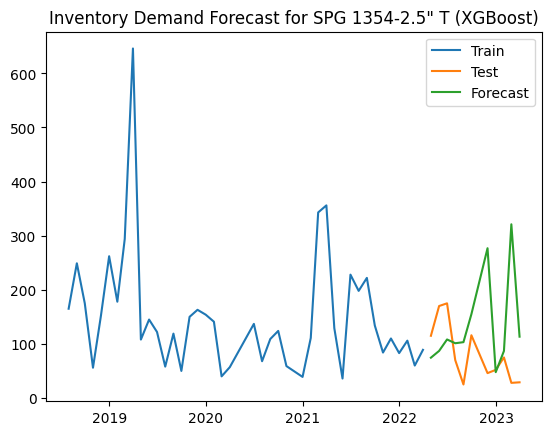

In [54]:
%%capture --no-display
    
def plot_forecast(train_data, test_data, y_train_pred, y_test_pred):
    plt.figure()
    plt.plot(train_data.index, train_data['Billed Quantity'], label='Train')
    plt.plot(test_data.index, test_data['Billed Quantity'], label='Test')
    plt.plot(train_data.index, y_train_pred, label='Train Forecast')
    plt.plot(test_data.index, y_test_pred, label='Test Forecast')
    plt.title('Inventory Demand Forecast (STL)')
    plt.legend()
    plt.show()

def visualize_all_forecasts_by_item(item_name, data, train_size=0.8, n_lags=12):
    print(f"Forecasts for item: {item_name}")
    
    models = [sarimax_forecast_item_demand, lstm_forecast_item_demand, stl_forecast_item_demand, lightgbm_forecast_item_demand, xgboost_forecast_item_demand]     
    for model in models:
        model(item_name, data, plot=True, train_size=train_size)

# Replace 'item_name' with the name of the item you want to forecast
item_name = "SPG 1354-2.5\" T"
visualize_all_forecasts_by_item(item_name, filtered_data)

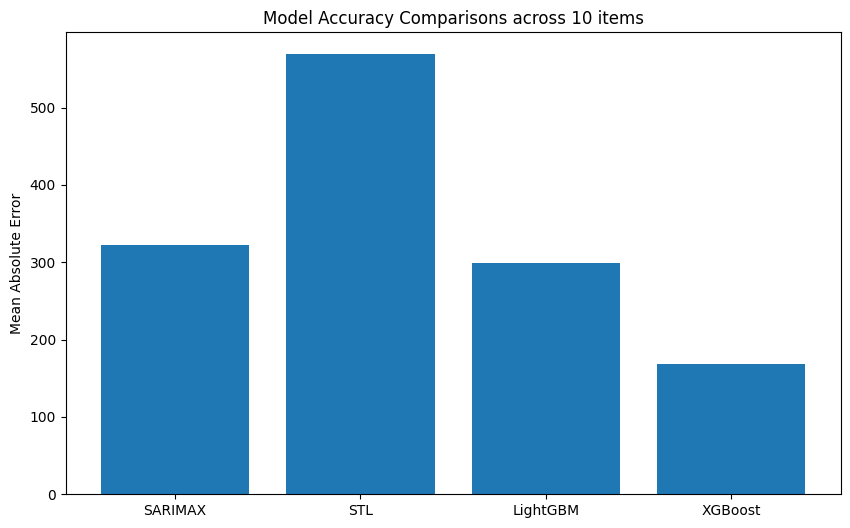

In [50]:
%%capture --no-display
def visualize_model_accuracy(data, train_size=0.8, n_lags=12, length=10):
    
    models = [sarimax_forecast_item_demand, stl_forecast_item_demand, lightgbm_forecast_item_demand, xgboost_forecast_item_demand]     
    model_names = ['SARIMAX', 'STL', 'LightGBM','XGBoost']
    model_mae_values = [get_mean_mae_across_products(model, length=length) for model in models]

    plt.figure(figsize=(10,6))
    plt.bar(model_names, model_mae_values)
    plt.ylabel('Mean Absolute Error')
    plt.title(f"Model Accuracy Comparisons across {length} items")
    plt.show()
    
visualize_model_accuracy(data=filtered_data)